# Assignment - Data Cleaning 3: Outliers - Checkpoint 4, Module 14: Model Preparation
### by Jaz Viccarro

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.stats import ttest_ind
from sqlalchemy import create_engine
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [5]:

missing = pd.DataFrame(df.isnull().sum() * 100 / len(df), columns=["Missing Values %"])
missing = missing.sort_values(by="Missing Values %", ascending=False)
missing = missing.round(0)
missing = missing[missing['Missing Values %'] != 0]
len(missing.index)
missing.index

df1 = df.copy()

states = df1['STATE'].unique() # use state as the index
missing_vals_cols = []

for item in missing.index:
        missing_vals_cols.append(item)

for state in states:
    df1.loc[df1["STATE"] == state, missing_vals_cols] = df1.loc[df1["STATE"] == state, missing_vals_cols].interpolate()

    df1.dropna(inplace=True)


#### 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?


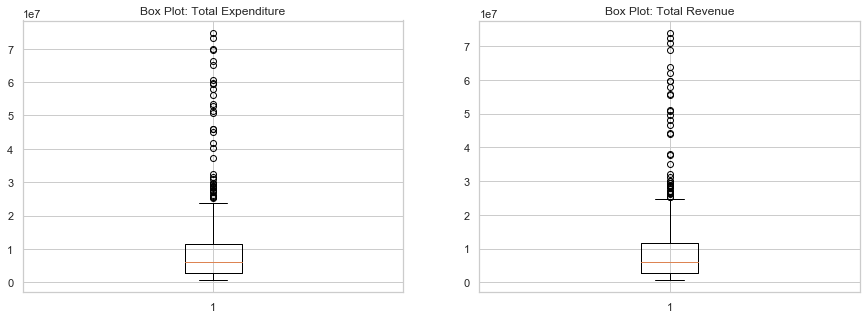

In [9]:
xs = df1['TOTAL_EXPENDITURE']
ys = df1['TOTAL_REVENUE']

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(xs)
plt.title('Box Plot: Total Expenditure')

plt.subplot(1,2,2)
plt.boxplot(ys)
plt.title('Box Plot: Total Revenue')
plt.show()

#### 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

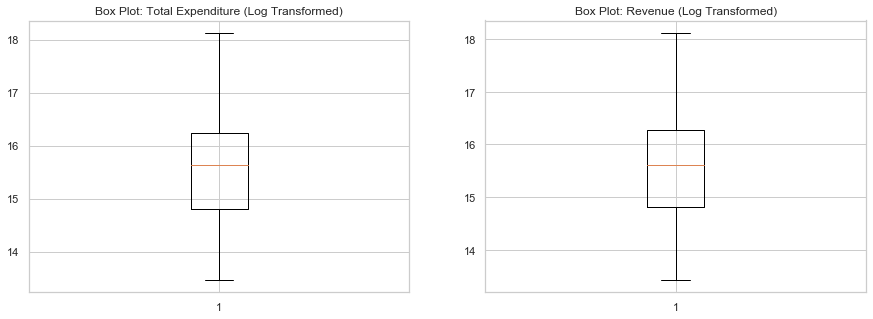

In [10]:
xt = np.log(df1['TOTAL_EXPENDITURE'])
yt = np.log(df1['TOTAL_REVENUE'])

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(xt)
plt.title('Box Plot: Total Expenditure (Log Transformed)')

plt.subplot(1,2,2)
plt.boxplot(yt)
plt.title('Box Plot: Revenue (Log Transformed)')
plt.show()

3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.


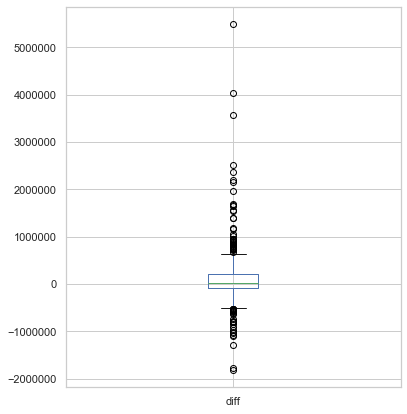

In [24]:
plt.figure(figsize = (6,7))

df1['diff'] = xs - ys #using vars from cells above
df1['diff'].plot(kind='box');
df1['diff_log'] = np.log(df1['diff']) # created new col 

#### Yes, there are outliers in this one, tons! 

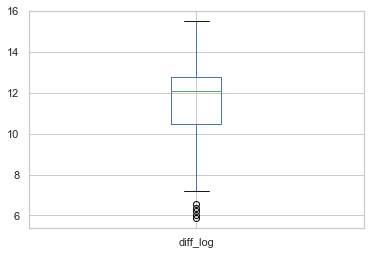

In [25]:
df1['diff_log'].plot(kind='box') #plot of log transform with original values

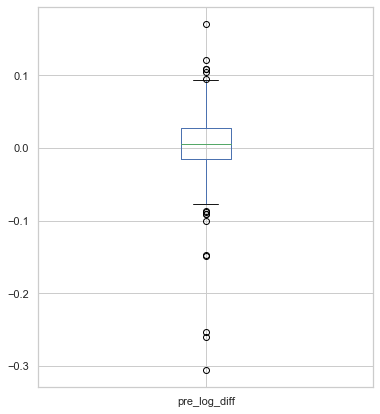

In [27]:
plt.figure(figsize = (6,7))

df1['pre_log_diff'] = xt - yt #using log transformed vars from cells above
# created the diff col with the already transformed data and then will transform the new col
df1['pre_log_diff'].plot(kind='box'); 

4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.


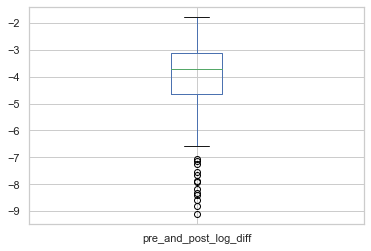

In [28]:
df1['pre_and_post_log_diff'] = np.log(df1['pre_log_diff'])
df1['pre_and_post_log_diff'].plot(kind='box')

#### now plot shows a reverse of the above, will need to apply a log to this column and then apply Tukey's Method

In [33]:
# now we take the log of the video views and calculate
# the quartiles accordingly.
q75, q25 = np.percentile(np.log(df1['pre_log_diff']), [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((np.log(df1['pre_log_diff']) > max_val) 
                      | (np.log(df1['pre_log_diff']) < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 0
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

In [64]:
df1[['diff', 'diff_log', 'pre_log_diff', 'pre_and_post_log_diff']].describe()
# pre_and_post_log_diff

,diff,diff_log,pre_log_diff,pre_and_post_log_diff
count,4.260000e+02,249.000000,426.000000,249.000000
mean,1.088853e+05,11.650955,0.004837,-4.032655
std,5.937355e+05,1.791525,0.045971,1.351152
min,-1.816932e+06,5.855072,-0.305521,-9.123215
25%,-8.165425e+04,10.491719,-0.015874,-4.634527
50%,1.695350e+04,12.105185,0.005374,-3.709336
75%,2.102780e+05,12.765171,0.027828,-3.128860
max,5.487742e+06,15.518027,0.170369,-1.769789


#### It appears that the diff_log displays the most normal looking variables, but most notable is the the change in standard deviation and the quartiles across transformations

6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

#### The method in the 4th question completely eliminated the outliers, so I believe that is the best method overall. 